In [1]:
import os,sys
import yt
import numpy as np
from numpy import log10 as log, log as ln
import pyxsim
import soxs
from yt import units as un, physical_constants as cons
sys.path.append('../pysrc/')

soxs : [WARNING  ] 2023-01-15 17:09:20,981 Setting 'soxs_data_dir' to /Users/jonathanstern/Library/Caches/soxs for this session. Please update your configuration if you want it somewhere else.


In [2]:
import projectPlotBasics

In [3]:
import pylab as pl
import matplotlib
from matplotlib import ticker
figdir = '/Users/jonathanstern/Dropbox/Apps/Overleaf/Analytic2D/'

rm: /Users/jonathanstern/Downloads/*.ewah: No such file or directory
yt : [INFO     ] 2023-01-15 17:16:58,840 Omega Lambda is 0.0, so we are turning off Cosmology.
yt : [INFO     ] 2023-01-15 17:16:58,840 Assuming length units are in kpc (physical)
yt : [INFO     ] 2023-01-15 17:16:58,870 Parameters: current_time              = 3.5499999672174454
yt : [INFO     ] 2023-01-15 17:16:58,871 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-01-15 17:16:58,872 Parameters: domain_left_edge          = None
yt : [INFO     ] 2023-01-15 17:16:58,872 Parameters: domain_right_edge         = None
yt : [INFO     ] 2023-01-15 17:16:58,873 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2023-01-15 17:16:58,886 Omega Lambda is 0.0, so we are turning off Cosmology.
yt : [INFO     ] 2023-01-15 17:16:58,887 Assuming length units are in kpc (physical)
yt : [INFO     ] 2023-01-15 17:16:58,914 Parameters: current_time              = 2.44999997317791
yt : [INFO     ] 2023-01-15 1

BH position [-0.01702357 -0.03651664 -0.00058411] code_length


yt : [INFO     ] 2023-01-15 17:17:06,366 Allocating for 6.253e+07 particles
yt : [INFO     ] 2023-01-15 17:17:06,366 Bounding box cannot be inferred from metadata, reading particle positions to infer bounding box
yt : [INFO     ] 2023-01-15 17:17:09,606 Load this dataset with bounding_box=[[-3604.31420898 -3571.93017578 -3585.05371094], [3577.61425781 3607.44946289 3590.23095703]] to avoid I/O overhead from inferring bounding_box.

Loading particle index: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 223/223 [00:00<00:00, 13440.38it/s]


BH position [ 0.02079579 -0.02846357 -0.00136999] code_length


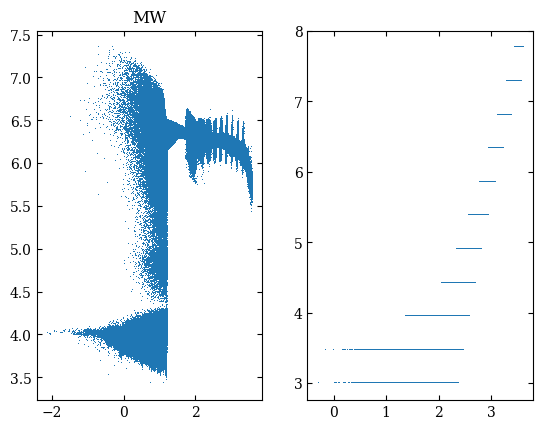

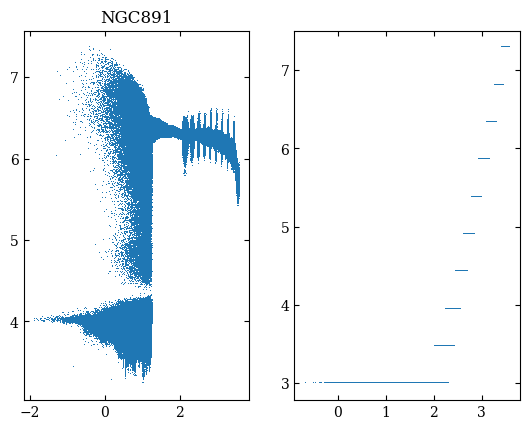

In [8]:
#Rcirc_sim = 10*un.kpc
Rcirc_sim = 15*un.kpc
os.system("rm /Users/jonathanstern/Downloads/*.ewah")
#ds = yt.load("/Users/jonathanstern/Downloads/snapshot_324.hdf5")
ds_MW = yt.load("/Users/jonathanstern/snapshot_071.hdf5")
ds_NGC891 = yt.load("/Users/jonathanstern/snapshot_049.hdf5")
dss = ds_MW,ds_NGC891; names = 'MW','NGC891'
#ds = yt.load("/Users/jonathanstern/Downloads/snapshot_009.hdf5")
for ids,ds in enumerate(dss):
    ad = ds.all_data()
    center = ad[ ('PartType5', 'Coordinates')][0]
    print('BH position', center)
    radius = ((ad[('PartType0','Coordinates')]-center)**2).sum(axis=1)**0.5
    pl.figure()
    pl.subplot(121)
    pl.plot(log(radius),log(ad[('PartType0','temperature')].value),',')
    pl.title(names[ids])
    pl.subplot(122)
    pl.plot(log(ad[('gas','radius')]/3e21),log(ad[('gas','mass')].value/2e33),',')

In [9]:
#NGC891
d = 9.52*un.Mpc #Bregmann22
Rcirc = Rcirc_sim 
size_ratio = 1 #(Rcirc/Rcirc_sim).value 
#Rcirc = (13.18/2*un.arcminute).to('radian')*d.to('kpc') #Bregmann22
#size_ratio = (Rcirc/Rcirc_sim).value 

In [12]:
def _kSZ_integrand(field, data, coeff = cons.sigma_thompson/cons.c):
    return coeff * data["gas", "El_number_density"] * data["gas", "velocity_x"]
ds = dss[1]
ds.add_field(
    name=("gas", "kSZ_integrand"),
    function=_kSZ_integrand,
    sampling_type="local",
    units="cm**-1",
)

yt : [WARNING  ] 2023-01-15 17:17:35,594 Field ('gas', 'kSZ_integrand') already exists. To override use `force_override=True`.


In [13]:
# define hot gas filter
def hot_CGM(pfilter, data):
    pfilter1 = data[pfilter.filtered_type, "temperature"] > 3.0e5*un.K
    pfilter2 = data[pfilter.filtered_type, "radius"] < 200*un.kpc
    return pfilter1 & pfilter2
yt.add_particle_filter("hot_gas", function=hot_CGM, filtered_type='gas', requires=["temperature","radius"])
ds.add_particle_filter('hot_gas')

yt : [WARNING  ] 2023-01-15 17:17:37,741 The hot_gas particle filter already exists. Overriding.


True

In [ ]:
#plot = yt.ProjectionPlot(ds, 0, ("gas", "temperature"), center=center,
#                        width=(200,'kpc'),buff_size=(200,200))
#plot.show()

In [15]:
pixel_physical_size = (1*un.arcminute).to('radian')*d.to('kpc') #Battaglia+17
fld = "kSZ_integrand"
width_in_kpc = 150
Npixels = width_in_kpc // pixel_physical_size.value
plot = yt.ProjectionPlot(ds, 0, ("hot_gas", fld), center=center,method="integrate",
                        width=(width_in_kpc/size_ratio,'kpc'),buff_size=(Npixels,Npixels))
kSZ = plot.to_fits_data()[fld].data
X,Y = [np.linspace(-width_in_kpc//2,width_in_kpc//2,int(Npixels)) for _ in range(2)]

yt : [INFO     ] 2023-01-15 17:18:04,792 xlim = -75.028464 74.971536
yt : [INFO     ] 2023-01-15 17:18:04,793 ylim = -75.001370 74.998630
yt : [INFO     ] 2023-01-15 17:18:04,793 xlim = -75.028464 74.971536
yt : [INFO     ] 2023-01-15 17:18:04,794 ylim = -75.001370 74.998630
yt : [INFO     ] 2023-01-15 17:18:04,795 Making a fixed resolution buffer of (('hot_gas', 'kSZ_integrand')) 54 by 54
yt : [INFO     ] 2023-01-15 17:18:53,415 Making a FITS image of field kSZ_integrand


In [17]:
DT = kSZ*2.7 * 1e6
Xmesh,Ymesh = np.meshgrid(X,Y)
mask = ~((np.abs(Xmesh)<25) & (np.abs(Ymesh)<5))
DT_tuple = X,Y,DT * mask

In [18]:
emin_in_keV = 0.54
emax_in_keV = 0.59
nbins = 1000
Zmet = 0.3 # this dataset does not have a metallicity field, so assume 0.3 Zsolar
source_model = pyxsim.CIESourceModel("apec", emin_in_keV, emax_in_keV, nbins, Zmet)

pyxsim : [INFO     ] 2023-01-15 17:19:57,519 kT_min = 0.025 keV
pyxsim : [INFO     ] 2023-01-15 17:19:57,519 kT_max = 64.0 keV


# plot spectrum with thermal broadening only

In [19]:
sp = ds.sphere(center,200*un.kpc)
spec = source_model.make_spectrum(sp, emin_in_keV,emax_in_keV, nbins)

pyxsim : [INFO     ] 2023-01-15 17:20:05,165 Using emission measure field '('gas', 'emission_measure')'.
pyxsim : [INFO     ] 2023-01-15 17:20:05,165 Using temperature field '('gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Processing cells/particles :   0%|          | 0/45759886 [00:00<?, ?it/s]

Text(0.5, 0, 'energy [keV]')

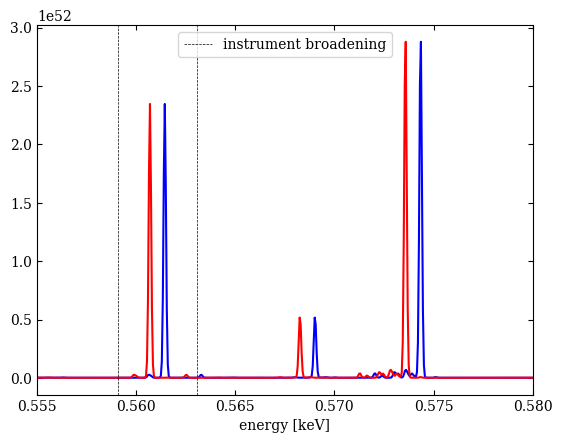

In [20]:
v_th = ((cons.kb*2e6*un.K/(16*cons.mp))**0.5).to('km/s')
v_phi = 200*un.km/un.s
v_inst = 0.002/0.56 * cons.c.to('km/s')

line_center = 0.561065*un.keV
for j in range(2):
    pl.plot(spec.emid*(1+(v_phi/cons.c).to(''))**((-1)**j),spec.flux,c='br'[j])
    pl.axvline(line_center.value*(1+(v_inst/cons.c).to(''))**((-1)**j),c='k',ls='--',lw=0.5,label=('instrument broadening','_')[j])
pl.xlim(0.555,0.58)
pl.legend()
pl.xlabel('energy [keV]')

In [21]:
#single line flux
emin_in_keV = 0.56
emax_in_keV = 0.563 
xray_fields = source_model.make_source_fields(ds, emin_in_keV, emax_in_keV)
xray_fields

pyxsim : [INFO     ] 2023-01-15 17:24:40,129 Using emission measure field '('gas', 'emission_measure')'.
pyxsim : [INFO     ] 2023-01-15 17:24:40,129 Using temperature field '('gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

[('gas', 'xray_emissivity_0.56_0.563_keV'),
 ('gas', 'xray_luminosity_0.56_0.563_keV'),
 ('gas', 'xray_photon_emissivity_0.56_0.563_keV')]

In [22]:
#LEM
Npixels_to_sum = 1 #in one dimension
d=40*un.Mpc
pixel_angular_size  = 15*un.arcsecond
pixel_physical_size = (Npixels_to_sum*pixel_angular_size).to('radian').value*d.to('kpc') #LEM paper
FOV_in_pixels = 118*2
img_width_physical = pixel_physical_size*FOV_in_pixels
img_Npixels = FOV_in_pixels
pixel_area = (img_width_physical/img_Npixels)**2
A_LEM = 1600*un.cm**2
geometric_dilution = (A_LEM / (4*np.pi*d**2)).to('')

In [23]:
fld = 'xray_emissivity_0.56_0.563_keV'
X,Y = [np.linspace(-img_width_physical//2,img_width_physical//2,int(img_Npixels)) for _ in range(2)]
Xmesh,Ymesh = np.meshgrid(X,Y)
mask = ~((np.abs(Xmesh)<25) & (np.abs(Ymesh)<5))

In [24]:
plot = yt.ProjectionPlot(ds, 0, ("gas", fld), center=center,method="integrate",
                        width=img_width_physical/size_ratio,buff_size=(img_Npixels,img_Npixels))
emission = plot.to_fits_data()[fld].data 
cnts = (emission * pixel_area * geometric_dilution  / line_center / (2.35*v_inst/cons.c*line_center)).to('s**-1*keV**-1')

yt : [INFO     ] 2023-01-15 17:24:57,492 xlim = -343.276550 343.219623
yt : [INFO     ] 2023-01-15 17:24:57,494 ylim = -343.249456 343.246716
yt : [INFO     ] 2023-01-15 17:24:57,495 xlim = -343.276550 343.219623
yt : [INFO     ] 2023-01-15 17:24:57,496 ylim = -343.249456 343.246716
yt : [INFO     ] 2023-01-15 17:24:57,497 Making a fixed resolution buffer of (('gas', 'xray_emissivity_0.56_0.563_keV')) 236 by 236
yt : [INFO     ] 2023-01-15 17:26:03,483 Making a FITS image of field xray_emissivity_0.56_0.563_keV


/var/folders/qg/7mjbrncj6tg4pn8hk8h33jbw0000gn/T/ipykernel_26852/2346948870.py:3: UserWarning: The following kwargs were not used by contour: 'c'
  pl.contour(X,Y,cnts,[0.02],c='k') #foreground


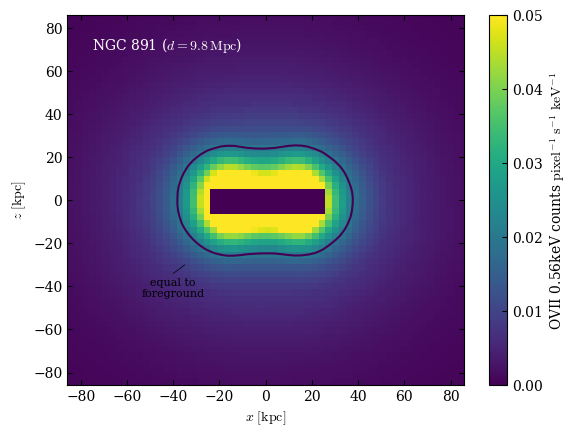

In [31]:
pl.pcolormesh(X,Y,cnts*mask,cmap='viridis',vmax=0.05)
pl.colorbar(label=r'OVII 0.56keV counts ${\rm pixel}^{-1}\ {\rm s}^{-1}\ {\rm keV}^{-1}$')
pl.contour(X,Y,cnts,[0.02],c='k') #foreground
pl.xlim(-img_width_physical/2/4,img_width_physical/2/4)
pl.ylim(-img_width_physical/2/4,img_width_physical/2/4)
pl.xlabel(r'$x\ [{\rm kpc}]$')
pl.ylabel(r'$z\ [{\rm kpc}]$')
pl.text(-75,70,r'NGC 891 ($d=9.8\,{\rm Mpc}$)',color='w')
pl.text(-40,-45,'equal to\nforeground',color='k',fontsize=8,ha='center')
pl.plot([-40,-35],[-34,-30],c='k',lw=0.5)

In [32]:
plot = yt.ProjectionPlot(ds, 0, ("gas","velocity_x"),weight_field=("gas", fld), center=center,
                         method="integrate",
                        width=img_width_physical/size_ratio,buff_size=(img_Npixels,img_Npixels))
emission_weighted_velocity = plot.to_fits_data()["velocity_x"].data.to('km/s')
emission_weighted_velocity_tuple = X,Y,emission_weighted_velocity*mask

yt : [INFO     ] 2023-01-15 17:28:18,574 xlim = -343.276550 343.219623
yt : [INFO     ] 2023-01-15 17:28:18,576 ylim = -343.249456 343.246716
yt : [INFO     ] 2023-01-15 17:28:18,577 xlim = -343.276550 343.219623
yt : [INFO     ] 2023-01-15 17:28:18,577 ylim = -343.249456 343.246716
yt : [INFO     ] 2023-01-15 17:28:18,579 Making a fixed resolution buffer of (('gas', 'velocity_x')) 236 by 236
yt : [INFO     ] 2023-01-15 17:29:27,522 Making a fixed resolution buffer of (('gas', 'xray_emissivity_0.56_0.563_keV')) 236 by 236
yt : [INFO     ] 2023-01-15 17:30:33,402 Making a FITS image of field velocity_x


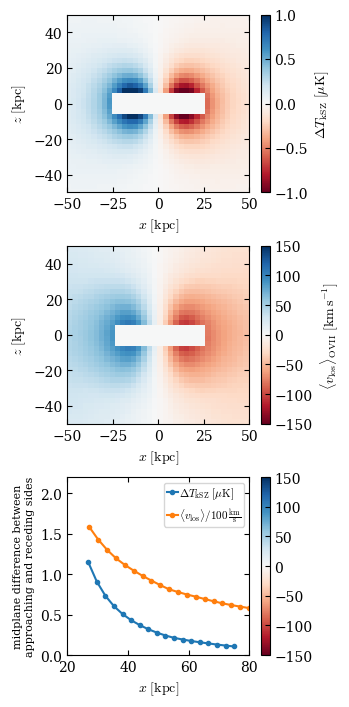

In [38]:
xrng = 50;
fig = pl.figure(figsize=(3.5,7))
gs  = matplotlib.gridspec.GridSpec(ncols=1, nrows=3)
pl.subplots_adjust(hspace=0.3,left=0.2,right=0.85,wspace=0.4,top=0.99,bottom=0.075)
for iobs in range(2):
    X,Y,vals = (DT_tuple,emission_weighted_velocity_tuple)[iobs]
    mid,ind = len(Y)//2,np.searchsorted(X,-26)
    label = (r'$\Delta T_{\rm kSZ}\ [\mu{\rm K}]$',r'$\langle v_{\rm los}\rangle_{\rm OVII}\ [{\rm km}\,{\rm s}^{-1}]$')[iobs]
    vrng=(1,150)[iobs]        
    ax = fig.add_subplot(gs[iobs])
    pl.pcolormesh(X,Y,vals,cmap='RdBu',vmin=-vrng,vmax=vrng)
    pl.colorbar(label=label)
    pl.ylabel(r'$z\ [{\rm kpc}]$')
    pl.xlim(-xrng,xrng)
    pl.ylim(-xrng,xrng)
    pl.xlabel(r'$x\ [{\rm kpc}]$')
ax = fig.add_subplot(gs[2])
for iobs in range(2):
    if iobs==0:
        X,Y,vals = DT_tuple
        label = r'$\Delta T_{\rm kSZ}\ [\mu{\rm K}]$'
        norm = 1
    else:
        X,Y,vals = emission_weighted_velocity_tuple
        label = r'$\langle v_{\rm los}\rangle /100\,\frac{\rm km}{\rm s}$'
        norm = 100
    mid,ind = len(Y)//2,np.searchsorted(X,-26)
    pl.plot(X[len(X)-ind:],(vals[mid,:ind][::-1]-vals[mid,len(X)-ind:])/norm,'.-',label=label)
pl.xlim(20,80)
pl.ylabel('midplane difference between\napproaching and receding sides',fontsize=8)
pl.ylim(0,2.2)
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
pl.xlabel(r'$x\ [{\rm kpc}]$')
pl.legend(handletextpad=0.1,borderpad=0.25,handlelength=1,fontsize=8)
cb = pl.colorbar(ax=ax); cb.set_alpha(0)
pl.savefig(figdir+'observed_velocity.png')

# anisotropy

In [41]:
#single line flux
emin_in_keV = 0.5
emax_in_keV = 2
xray_fields = source_model.make_source_fields(ds, emin_in_keV, emax_in_keV)
xray_fields

pyxsim : [INFO     ] 2023-01-15 17:38:57,234 Using emission measure field '('gas', 'emission_measure')'.
pyxsim : [INFO     ] 2023-01-15 17:38:57,237 Using temperature field '('gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

[('gas', 'xray_emissivity_0.5_2_keV'),
 ('gas', 'xray_luminosity_0.5_2_keV'),
 ('gas', 'xray_photon_emissivity_0.5_2_keV')]

In [42]:
#LEM
d=40*un.Mpc
pixel_angular_size  = 1*un.arcsecond
pixel_physical_size = (Npixels_to_sum*pixel_angular_size).to('radian').value*d.to('kpc') #LEM paper
FOV_in_pixels = 2000
img_width_physical = pixel_physical_size*FOV_in_pixels
img_Npixels = FOV_in_pixels
pixel_area = (img_width_physical/img_Npixels)**2
A_LEM = 1600*un.cm**2
geometric_dilution = (A_LEM / (4*np.pi*d**2)).to('')


In [43]:
Npixels_to_sum = 1 #in one dimension
fld = 'xray_photon_emissivity_0.5_2_keV'
X,Y = [np.linspace(-img_width_physical//2,img_width_physical//2,int(img_Npixels)) for _ in range(2)]
Xmesh,Ymesh = np.meshgrid(X,Y)
mask = ~((np.abs(Xmesh)<25) & (np.abs(Ymesh)<5))

In [44]:
plot = yt.ProjectionPlot(ds, 0, ("gas", fld), center=center,method="integrate",
                        width=img_width_physical/size_ratio,buff_size=(img_Npixels,img_Npixels))
emission = plot.to_fits_data()[fld].data 
cnts = (emission * pixel_area * geometric_dilution).to('s**-1')

yt : [INFO     ] 2023-01-15 17:39:13,565 xlim = -193.953936 193.897009
yt : [INFO     ] 2023-01-15 17:39:13,566 ylim = -193.926842 193.924102
yt : [INFO     ] 2023-01-15 17:39:13,567 xlim = -193.953936 193.897009
yt : [INFO     ] 2023-01-15 17:39:13,568 ylim = -193.926842 193.924102
yt : [INFO     ] 2023-01-15 17:39:13,569 Making a fixed resolution buffer of (('gas', 'xray_photon_emissivity_0.5_2_keV')) 2000 by 2000
yt : [INFO     ] 2023-01-15 17:41:58,573 Making a FITS image of field xray_photon_emissivity_0.5_2_keV


In [45]:
#single line flux
nbins = 1000
Zmet = 0.3 # this dataset does not have a metallicity field, so assume 0.3 Zsolar
emin_in_keV = 0.56
emax_in_keV = 0.563 
source_model1 = pyxsim.CIESourceModel("apec", emin_in_keV, emax_in_keV, nbins, Zmet)
xray_fields1= source_model1.make_source_fields(ds, emin_in_keV, emax_in_keV,force_override=True)
emin_in_keV = 0.64
emax_in_keV = 0.68 
source_model2 = pyxsim.CIESourceModel("apec", emin_in_keV, emax_in_keV, nbins, Zmet)
xray_fields2= source_model2.make_source_fields(ds, emin_in_keV, emax_in_keV,force_override=True)


pyxsim : [INFO     ] 2023-01-15 17:41:58,637 kT_min = 0.025 keV
pyxsim : [INFO     ] 2023-01-15 17:41:58,638 kT_max = 64.0 keV
pyxsim : [INFO     ] 2023-01-15 17:41:58,639 Using emission measure field '('gas', 'emission_measure')'.
pyxsim : [INFO     ] 2023-01-15 17:41:58,639 Using temperature field '('gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Initializing refined index:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 197/223 [30:30<04:01,  9.29s/it]
pyxsim : [INFO     ] 2023-01-15 17:42:00,280 kT_min = 0.025 keV
pyxsim : [INFO     ] 2023-01-15 17:42:00,280 kT_max = 64.0 keV
pyxsim : [INFO     ] 2023-01-15 17:42:00,281 Using emission measure field '('gas', 'emission_measure')'.
pyxsim : [INFO     ] 2023-01-15 17:42:00,281 Using temperature field '('gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

In [46]:
plot = yt.ProjectionPlot(ds, 0, xray_fields1[0], center=center,method="integrate",
                        width=img_width_physical/size_ratio,buff_size=(img_Npixels,img_Npixels))
LOVII_emission = plot.to_fits_data()[xray_fields1[0][1]].data 

yt : [INFO     ] 2023-01-15 17:42:01,754 xlim = -193.953936 193.897009
yt : [INFO     ] 2023-01-15 17:42:01,755 ylim = -193.926842 193.924102
yt : [INFO     ] 2023-01-15 17:42:01,755 xlim = -193.953936 193.897009
yt : [INFO     ] 2023-01-15 17:42:01,756 ylim = -193.926842 193.924102
yt : [INFO     ] 2023-01-15 17:42:01,757 Making a fixed resolution buffer of (('gas', 'xray_emissivity_0.56_0.563_keV')) 2000 by 2000
yt : [INFO     ] 2023-01-15 17:44:47,785 Making a FITS image of field xray_emissivity_0.56_0.563_keV


In [47]:
plot = yt.ProjectionPlot(ds, 0, xray_fields2[0], center=center,method="integrate",
                        width=img_width_physical/size_ratio,buff_size=(img_Npixels,img_Npixels))
LOVIII_emission = plot.to_fits_data()[xray_fields2[0][1]].data 

yt : [INFO     ] 2023-01-15 17:44:47,795 xlim = -193.953936 193.897009
yt : [INFO     ] 2023-01-15 17:44:47,795 ylim = -193.926842 193.924102
yt : [INFO     ] 2023-01-15 17:44:47,795 xlim = -193.953936 193.897009
yt : [INFO     ] 2023-01-15 17:44:47,796 ylim = -193.926842 193.924102
yt : [INFO     ] 2023-01-15 17:44:47,796 Making a fixed resolution buffer of (('gas', 'xray_emissivity_0.64_0.68_keV')) 2000 by 2000
yt : [INFO     ] 2023-01-15 17:47:34,585 Making a FITS image of field xray_emissivity_0.64_0.68_keV


In [48]:
ratio = LOVIII_emission/LOVII_emission

/var/folders/qg/7mjbrncj6tg4pn8hk8h33jbw0000gn/T/ipykernel_26852/3534074115.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(ticker.FixedFormatter([r'$0$',r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$',r'$\pi$']))


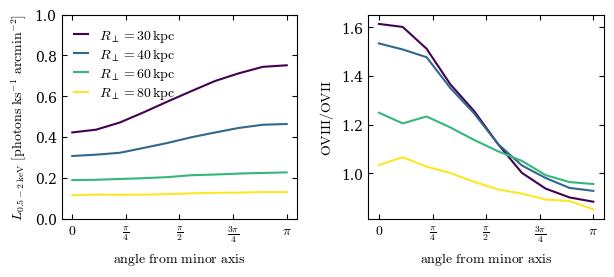

In [58]:
fig = pl.figure(figsize=(7,3.))
pl.subplots_adjust(wspace=0.3,bottom=0.2)
rs = np.array([30,40,60,80])
thetas=np.linspace(0,np.pi/2,10)
for iPanel in range(2):
    ax = pl.subplot(1,2,iPanel+1)
    for ir,r in enumerate(rs):
        c = pl.get_cmap('viridis')(ir/(len(rs)-1))
        iX = np.searchsorted(X,r*np.sin(thetas))
        iY = np.searchsorted(Y,r*np.cos(thetas))
        if iPanel==0:
            pl.plot(thetas, cnts[iY,iX]*3600e3,label=r'$R_\perp=%d\,{\rm kpc}$'%r,c=c)
        if iPanel==1:
            pl.plot(thetas, ratio[iY,iX],label=r'$R_\perp=%d\,{\rm kpc}$'%r,c=c)
    if iPanel==0:
        pl.ylabel(r'$L_{0.5-2\,{\rm keV}}\ [{\rm photons}\ {\rm ks}^{-1}\ {\rm arcmin}^{-2}]$')
        pl.legend(frameon=False,handlelength=1,labelspacing=0.15)
        pl.ylim(0,1)
    if iPanel==1:            
        pl.ylabel(r'${\rm OVIII}/{\rm OVII}$')
    ax.xaxis.set_major_formatter(ticker.FixedFormatter([r'$0$',r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$',r'$\pi$']))
    ax.xaxis.set_major_locator(ticker.FixedLocator(np.linspace(0,1,5)*np.pi/2))        
    pl.xlabel(r'${\rm angle\ from\ minor\ axis}$')
pl.savefig(figdir+'theta_dependence_observed.pdf')


# FRB columns

In [59]:
ds = dss[0] #Milky Way
region = ds.r[-200:200:400j, -200:200:400j, -200:200:400j]
xs = np.linspace(-200,200,400)
n_elec = region[("gas","El_number_density")]
Ts = region[("gas","temperature")]


Interpolating SPH field ('PartType0', 'El_number_density'): 0it [00:00, ?it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 50000it [00:00, 307089.19it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 150000it [00:00, 534936.66it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 300000it [00:00, 830774.75it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 400000it [00:00, 787385.48it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 550000it [00:00, 787474.34it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 750000it [00:00, 1057172.34it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 900000it [00:00, 1159672.49it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 1050000it [00:01, 1165434.93it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 1200000it [00:01, 1190652.71it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 1350000it [00:01, 1053941.2

Interpolating SPH field ('PartType0', 'El_number_density'): 13250000it [00:13, 818050.40it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 13350000it [00:13, 771272.62it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 13600000it [00:13, 1094518.73it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 13850000it [00:13, 1182665.73it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 14000000it [00:13, 1104188.31it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 14150000it [00:13, 1079291.27it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 14300000it [00:13, 1115622.68it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 14450000it [00:14, 945624.01it/s] 
Interpolating SPH field ('PartType0', 'El_number_density'): 14600000it [00:14, 922717.45it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 14700000it [00:14, 878945.65it/s]
Interpolating SPH field ('PartType0', 'El_number_densi

Interpolating SPH field ('PartType0', 'El_number_density'): 27150000it [00:26, 915259.97it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 27300000it [00:26, 960502.95it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 27450000it [00:27, 928828.52it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 27600000it [00:27, 945469.29it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 27800000it [00:27, 1100624.01it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 27950000it [00:27, 946928.21it/s] 
Interpolating SPH field ('PartType0', 'El_number_density'): 28100000it [00:27, 818468.83it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 28250000it [00:27, 780703.57it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 28350000it [00:28, 818690.61it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 28450000it [00:28, 801807.47it/s]
Interpolating SPH field ('PartType0', 'El_number_density')

Interpolating SPH field ('PartType0', 'El_number_density'): 39450000it [00:40, 878343.29it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 39700000it [00:40, 1061491.62it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 39850000it [00:40, 862379.47it/s] 
Interpolating SPH field ('PartType0', 'El_number_density'): 39950000it [00:41, 856673.34it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 40100000it [00:41, 828545.80it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 40200000it [00:41, 829532.09it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 40300000it [00:41, 748912.29it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 40450000it [00:41, 894644.04it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 40600000it [00:41, 1003518.10it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 40750000it [00:41, 990231.65it/s] 
Interpolating SPH field ('PartType0', 'El_number_density

Interpolating SPH field ('PartType0', 'El_number_density'): 53850000it [00:54, 913703.50it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 53950000it [00:54, 912844.24it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 54050000it [00:54, 868585.18it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 54150000it [00:54, 806652.73it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 54250000it [00:54, 733445.48it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 54400000it [00:55, 817622.94it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 54500000it [00:55, 820383.58it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 54650000it [00:55, 887600.99it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 54750000it [00:55, 754846.93it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 54950000it [00:55, 999064.00it/s]
Interpolating SPH field ('PartType0', 'El_number_density'): 

Interpolating SPH field ('PartType0', 'Temperature'): 5600000it [00:05, 974775.73it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 5800000it [00:06, 1150831.47it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 5950000it [00:06, 917897.44it/s] 
Interpolating SPH field ('PartType0', 'Temperature'): 6100000it [00:06, 850462.37it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 6250000it [00:06, 894995.99it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 6500000it [00:06, 1204943.27it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 6750000it [00:06, 1316479.91it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 7000000it [00:07, 1405972.04it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 7250000it [00:07, 1315671.18it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 7400000it [00:07, 1337373.71it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 7550000it [00:07, 1351298.60it/s]
Interpolating SPH field ('PartType0

Interpolating SPH field ('PartType0', 'Temperature'): 21250000it [00:20, 986887.19it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 21550000it [00:20, 1299889.18it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 21750000it [00:20, 1343904.79it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 21950000it [00:20, 1426473.71it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 22150000it [00:20, 1499336.24it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 22350000it [00:20, 1241118.77it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 22550000it [00:21, 1294796.26it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 22700000it [00:21, 1241327.09it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 22850000it [00:21, 946531.72it/s] 
Interpolating SPH field ('PartType0', 'Temperature'): 23100000it [00:21, 1029570.86it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 23250000it [00:21, 1032369.32it/s]
Interpolating SPH fiel

Interpolating SPH field ('PartType0', 'Temperature'): 35900000it [00:34, 1036402.89it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 36050000it [00:35, 808933.73it/s] 
Interpolating SPH field ('PartType0', 'Temperature'): 36200000it [00:35, 765182.52it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 36350000it [00:35, 803212.86it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 36500000it [00:35, 804362.47it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 36600000it [00:35, 838864.70it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 36750000it [00:36, 753607.70it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 36850000it [00:36, 798113.45it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 36950000it [00:36, 687813.26it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 37150000it [00:36, 910992.73it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 37300000it [00:36, 818474.33it/s]
Interpolating SPH field ('Part

Interpolating SPH field ('PartType0', 'Temperature'): 50450000it [00:49, 1319390.52it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 50650000it [00:49, 1371364.31it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 50800000it [00:49, 1264171.66it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 50950000it [00:49, 1191544.92it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 51100000it [00:49, 1079864.93it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 51250000it [00:50, 846423.20it/s] 
Interpolating SPH field ('PartType0', 'Temperature'): 51350000it [00:50, 864517.73it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 51550000it [00:50, 968831.19it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 51700000it [00:50, 986611.09it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 51850000it [00:50, 864377.88it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 52000000it [00:50, 924369.84it/s]
Interpolating SPH field ('

In [77]:
import scipy, scipy.interpolate
center = np.array([0.,0., 0.])
sun_offset = np.array([8.,0., 0.])
ray_length = 100
Npoints = 1000
dl = ray_length / Npoints
start_loc = center+sun_offset
bs = np.linspace(np.pi/6,np.pi/2,15)
ls = np.linspace(0,np.pi,5)
DM = {}
for l in ls:
    DM[l] = np.zeros(bs.shape)
    for ib,b in enumerate(bs):
        phi,theta = l, np.pi/2-b
        unit_vector = np.array([np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi), np.cos(theta)])
        end_loc = start_loc + ray_length * unit_vector
        points = np.array([(end_loc - start_loc) / Npoints * i for i in np.arange(Npoints)]) + start_loc
        interpolated_n_elec = scipy.interpolate.interpn((xs,xs,xs),n_elec,points)
        interpolated_Ts = scipy.interpolate.interpn((xs,xs,xs),Ts,points)
        DM[l][ib] = (interpolated_n_elec * (interpolated_Ts>1e6)).sum()*dl

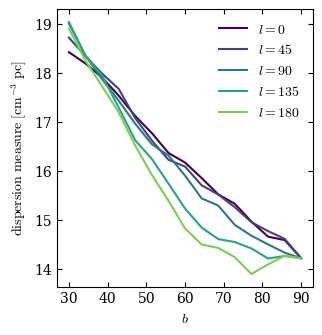

In [90]:
pl.figure(figsize=(3.5,3.6))
ax = pl.subplot(111)
pl.subplots_adjust(left=0.17)
for il,l in enumerate(ls):
    pl.plot(bs/np.pi*180,DM[l]*1000,label=r'$l=%d$'%(l/np.pi*180),c=pl.get_cmap('viridis')(il/len(ls)))
pl.xlabel(r'$b$')
pl.ylabel(r'${\rm dispersion~measure}\ [{\rm cm}^{-3}\ {\rm pc}]$')
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
pl.legend(frameon=False)
pl.savefig(figdir+'FRB_DM.pdf')

In [62]:
1e-3*15*3e21/3e18

15.0

In [62]:
obj = ds.arbitrary_grid([-200, -200, -200], [200, 200, 200], dims=[128, 128, 128])


In [68]:
print(obj["deposit", "gas_density"])


YTFieldNotFound: Could not find field ('deposit', 'gas_density') in snapshot_324.

In [78]:
sun_offset = ds.arr([0.,0., 0.], "kpc")
ray_length = 200*un.kpc
start_loc = center+sun_offset
bs = np.linspace(np.pi/6,np.pi/2,10)
ls = np.linspace(0,np.pi,5)
DM = {}
for l in ls:
    DM[l] = np.zeros(bs.shape)
    for ib,b in enumerate(bs):
        phi,theta = l, np.pi/2-b
        unit_vector = ds.arr([np.cos(theta)*np.cos(phi),np.sin(theta)*np.sin(phi), np.cos(theta)])
        end_loc = start_loc + ray_length * unit_vector
        my_ray = ds.r[start_loc:end_loc:100j]
        #print(l,b,my_ray["dts"].sum())
        #DM[l][ib] = (my_ray[("gas","El_number_density")] * my_ray["dts"] * (my_ray[("gas","temperature")]>1e6*un.K)).sum()*ray_length

In [84]:
my_ray[("gas","El_number_density")]

YTNonIndexedDataContainer: The data container type (ParticleContainer) is an unindexed type. Operations such as ires, icoords, fcoords and fwidth will not work on it.
Did you just attempt to perform an off-axis operation ? Be sure to consult the latest documentation to see whether the operation you tried is actually supported for your data type.

In [ ]:
exp_time = (300., "ks") # exposure time
area = (1600.0, "cm**2") # collecting area
redshift = 0.002

In [221]:
res = (15*un.arcsecond).to('radian')*d.to('kpc') #LEM paper
size_ratio = (Rcirc/Rcirc_sim).value #better run a sim with correct size
fld = "velocity_x"
width_in_kpc = 100
Npixels = width_in_kpc // res.value
plot = yt.ProjectionPlot(ds, 0, ("gas", fld), center=center,method="integrate",
                         weight_field=xray_fields[0],
                        width=(width_in_kpc/size_ratio,'kpc'),buff_size=(Npixels,Npixels))
projected = plot.to_fits_data()[fld].data
X,Y = [np.linspace(-width_in_kpc//2,width_in_kpc//2,int(Npixels)) for _ in range(2)]
#plot.set_unit(("hot_gas", "velocity_x"), "km/s")
#plot.save()

yt : [INFO     ] 2022-12-13 15:36:10,777 xlim = -27.387737 27.408599
yt : [INFO     ] 2022-12-13 15:36:10,778 ylim = -27.398981 27.397355
yt : [INFO     ] 2022-12-13 15:36:10,781 xlim = -27.387737 27.408599
yt : [INFO     ] 2022-12-13 15:36:10,782 ylim = -27.398981 27.397355
yt : [INFO     ] 2022-12-13 15:36:10,783 Making a fixed resolution buffer of (('gas', 'velocity_x')) 144 by 144
yt : [INFO     ] 2022-12-13 15:36:13,222 Making a fixed resolution buffer of (('gas', 'xray_emissivity_0.56_0.563_keV')) 144 by 144
yt : [INFO     ] 2022-12-13 15:36:15,606 Making a FITS image of field velocity_x


In [170]:
prj = yt.ProjectionPlot(ds, "z", xray_fields[-1], width=(0.5, "Mpc"))
prj.save()

yt : [INFO     ] 2022-12-13 15:03:36,608 xlim = -312.894897 187.105103
yt : [INFO     ] 2022-12-13 15:03:36,610 ylim = -181.483783 318.516217
yt : [INFO     ] 2022-12-13 15:03:36,611 xlim = -312.894897 187.105103
yt : [INFO     ] 2022-12-13 15:03:36,612 ylim = -181.483783 318.516217
yt : [INFO     ] 2022-12-13 15:03:36,613 Making a fixed resolution buffer of (('gas', 'xray_photon_emissivity_0.5_7.0_keV')) 800 by 800
yt : [INFO     ] 2022-12-13 15:03:44,987 Saving plot snapshot_324_Projection_z_xray_photon_emissivity_0.5_7.0_keV.png


['snapshot_324_Projection_z_xray_photon_emissivity_0.5_7.0_keV.png']

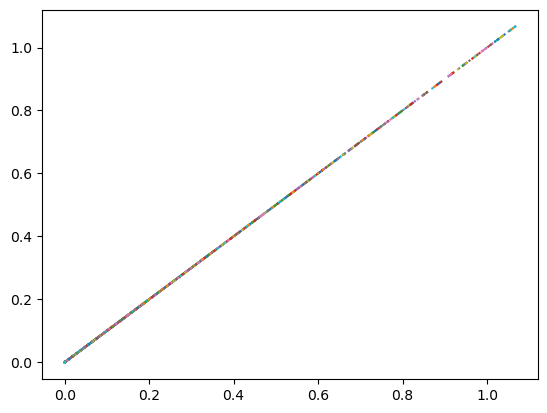

In [149]:
for i in range(len(my_ray["t"])):
    pl.plot([my_ray["t"][i],my_ray["t"][i]+my_ray["dts"][i]],[my_ray["t"][i],my_ray["t"][i]+my_ray["dts"][i]])
#%pl.semilogy()

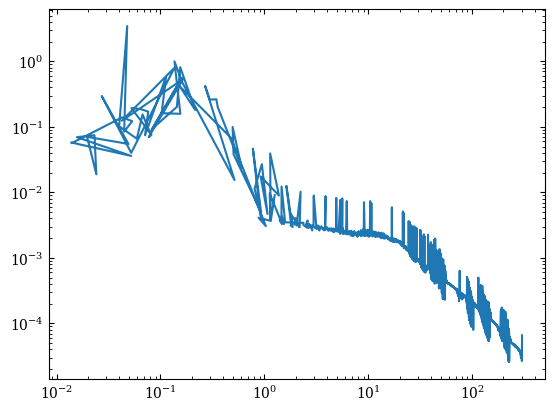

In [56]:
inds = my_ray["t"].argsort()
pl.loglog(my_ray["PartType0","BH_Dist"][inds],my_ray["gas","El_number_density"][inds])

In [57]:
l,b

(3.141592653589793, 1.5707963267948966)

In [88]:
plot = yt.SlicePlot(ds, "r", ("hot_gas", "El_number_density"), center=center,method="integrate")
                        #width=(width_in_kpc/size_ratio,'kpc'),buff_size=(Npixels,Npixels))


ValueError: 'r' is not a valid axis name. Expected one of 'x', 'y', 'z'.

In [ ]:
c_obs = c + ds.arr([8.,0., 0.], "code_length")
c_obs = ds.arr([8.,0., 0.], "code_length")
metals = ["He_fraction", "C_fraction", "N_fraction", "O_fraction",
          "Ne_fraction", "Mg_fraction", "Si_fraction", "Fe_fraction"]
var_elem = {elem.split("_")[0]: ("hot_gas", elem) for elem in metals}

# set up the source model

emin = 0.25 # The minimum energy to generate in keV
emax = 1.5 # The maximum energy to generate in keV
nbins = 5000 # The number of energy bins between emin and emax
kT_max = 2.0 # The max gas temperature to use
source_model = pyxsim.CIESourceModel(
    "apec", emin, emax, nbins, ("hot_gas","metallicity"),
    temperature_field=("hot_gas","temperature"),
    emission_measure_field=("hot_gas", "emission_measure"),
    kT_max=kT_max, var_elem=var_elem
)
exp_time = (50., "s") # exposure time
area = (5000.0, "cm**2") # collecting area
redshift = 0.0 # the cosmological redshift of the source, this source is local
width = ds.quan(1.0, "Mpc")
le = c - 0.5*width
re = c + 0.5*width
box = ds.box(le, re)
c = ds.arr([0,0,0], "code_length")
width = ds.quan(1.0, "Mpc")
le = c - 0.5*width
re = c + 0.5*width
box = ds.box(le, re)
n_photons, n_cells = pyxsim.make_photons("sub_494709_photons_internal", box,
                                         redshift, area, exp_time, source_model,
                                         center=c_obs, bulk_velocity=bulk_velocity,
                                         observer="internal")
v = ds.arr([0,0,0], "km/s")
n_photons, n_cells = pyxsim.make_photons("sub_494709_photons_internal", box,
                                         redshift, area, exp_time, source_model,
                                         center=c_obs, bulk_velocity=v,
                                         observer="internal")
ds.fields
sp
dir(ds)
ds.field_list
 pyxsim.CIESourceModel?
metals = ["He_fraction", "C_fraction", "N_fraction", "O_fraction",
          "Ne_fraction", "Mg_fraction", "Si_fraction", "Fe_fraction"]
var_elem = {elem.split("_")[0]: ("hot_gas", elem) for elem in metals}

# set up the source model

emin = 0.25 # The minimum energy to generate in keV
emax = 1.5 # The maximum energy to generate in keV
nbins = 5000 # The number of energy bins between emin and emax
kT_max = 2.0 # The max gas temperature to use
source_model = pyxsim.CIESourceModel(
    "apec", emin, emax, nbins, ("hot_gas","Metallicity_00"),
    temperature_field=("hot_gas","temperature"),
    emission_measure_field=("hot_gas", "emission_measure"),
    kT_max=kT_max)
n_photons, n_cells = pyxsim.make_photons("sub_494709_photons_internal", box,
                                         redshift, area, exp_time, source_model,
                                         center=c_obs, bulk_velocity=v,
                                         observer="internal")
ds.field_list
ad['PartType0', 'Velocities']
ad['PartType0', 'Velocities'].shape
yt.ProjectionPlot(ds, normal, ("gas", "velocity"), weight_field=("gas", "density")).save()
ys.ProjectionPlot
yt.ProjectionPlot
yt.ProjectionPlot?
yt.ProjectionPlot(ds, 1, ("gas", "velocity"), weight_field=("gas", "density")).save()
%history
dir(ds)
ds.add_field?

ds.add_field(
    name=("PartType0", "velocity_x"),
    function=_velocity_x,
    sampling_type="local",
    units="km/s",
)
yt.ProjectionPlot(ds, 1, ("PartType0", "velocity_x"), weight_field=("gas", "density")).save()
ds.sphere?
sp = ds.sphere(c, (100.0, "kpc"))
yt.ProjectionPlot(sp, 1, ("PartType0", "velocity_x"), weight_field=("gas", "density")).save()
sp.field_list
dir(sp)
yt.ProjectionPlot(sp.sa, 1, ("PartType0", "velocity_x"), weight_field=("gas", "density")).save()
yt.ProjectionPlot(sp.ds, 1, ("PartType0", "velocity_x"), weight_field=("gas", "density")).save()
plot = yt.ProfilePlot(
    my_sphere,
    ("index", "radius"),
    ("gas", "density"),
    weight_field=("gas", "mass"),
)
my_sphere = sp
plot = yt.ProfilePlot(
    my_sphere,
    ("index", "radius"),
    ("gas", "density"),
    weight_field=("gas", "mass"),
)
def _r(field, data):
    return (data["PartType0","Coordinates"]**2).sum()**0.5
ds.add_field(
    name=("PartType0", "radius"),
    function=_r,
    sampling_type="local",
    units="kpc",
)
plot = yt.ProfilePlot(
    my_sphere,
    ("PartType0", "radius"),
    ("gas", "density"),
    weight_field=("gas", "mass"),
    
)
plot.save()
plot.set_unit(("PartType0", "radius"), "kpc")
plot.save()
ds.derived_field_list
plot = yt.ProfilePlot(
    my_sphere,
    ("PartType0", "radius"),
    ("gas", "radial_velocity"),
    weight_field=("gas", "mass"),
)
yt.ProfilePlot(
    my_sphere,
    ("PartType0", "radius"),
    ("gas", "radial_velocity"),
    weight_field=("gas", "mass"),
).save()
yt.ProfilePlot?
yt.ProfilePlot(
    my_sphere,
    ("PartType0", "radius"),
    ("gas", "radial_velocity"),
    weight_field=("gas", "mass"),ylog=False,
).save()
yt.ProfilePlot?
yt.ProfilePlot(
    my_sphere,
    ("PartType0", "radius"),
    ("gas", "radial_velocity"),
    weight_field=("gas", "mass"),y_log=False,
).save()
plot.set_unit(("PartType0", "radius"), "kpc")
plot = yt.ProfilePlot(
    my_sphere,
    ("PartType0", "radius"),
    ("gas", "radial_velocity"),
    weight_field=("gas", "mass"),y_log=False,
).save()
yt.ProjectionPlot(sp.sa, 1, ("PartType0", "velocity_x"), weight_field=("gas", "masses"")).save()
yt.ProjectionPlot(sp.sa, 1, ("PartType0", "velocity_x"), weight_field=("gas", "masses")).save()
yt.ProjectionPlot(ds, 1, ("PartType0", "velocity_x"), weight_field=("gas", "masses")).save()
yt.ProjectionPlot(ds, 1, ("PartType0", "velocity_x"), weight_field=("PartType0", "masses")).save()
ds.derived_field_list
yt.ProjectionPlot(ds, 1, ("PartType0", "particle_velocity_y"), weight_field=("PartType0", "mass")).save()
yt.ProjectionPlot(sp.ds, 1, ("PartType0", "particle_velocity_y"), weight_field=("PartType0", "mass")).save()
yt.ProjectionPlot?
yt.ProjectionPlot?